In [1]:
""" Compare CKA to HE optimzation on sphere """
import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import random

# add all working directories to path
cwd = os.getcwd()
hyper_path = "/".join(cwd.split('/')[:-1])
if hyper_path not in sys.path:
    sys.path.append(hyper_path)

from hyper.diversity import hyperspherical_energy, batched_gram, pairwise_cossim
from hyper.diversity.uncertainty import entropy, entropy_prob
import seaborn as sns
sns.set_theme('paper', font_scale=1.25)
sns.set_style('white')
sns.set_style('ticks')


# set all seeds
random.seed(4)
np.random.seed(4)
torch.manual_seed(4)

# Create random point clusters on sphere


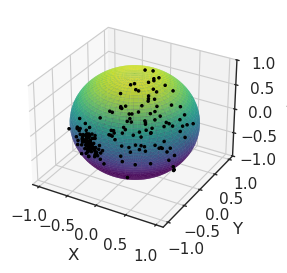

In [2]:
quad_one = torch.normal(3.0, 2.1, size=(100, 3))
quad_one[:, 1] *= -1
quad_one /= torch.norm(quad_one, dim=1, keepdim=True)

quad_two = -1.0 * torch.normal(9.0, 2.1, size=(100, 3))
quad_two[:, 0] += 5.0
quad_two[:, 1] *= 2.0
quad_two[:, 2] += 10.0
quad_two /= torch.norm(quad_two, dim=1, keepdim=True)

points = torch.cat([quad_one, quad_two], dim=0)

@torch.no_grad()
def plot_points(pt, save_name=None):
  if isinstance(pt, torch.Tensor):
    pt = pt.cpu().numpy()
  pt = pt / np.linalg.norm(pt, axis=1, keepdims=True)
  
  fig = plt.figure(figsize=(3, 3.5))
  ax = fig.add_subplot(projection='3d')
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)
  r = 0.975  # to avoid drawing over points/ easier to visualize
  x = r * np.outer(np.cos(u), np.sin(v))
  y = r * np.outer(np.sin(u), np.sin(v))
  z = r * np.outer(np.ones(np.size(u)), np.cos(v))
  ax.plot_surface(x, y, z, vmin=-0.5, cmap='viridis', alpha=0.8, edgecolors='none')
  ax.set_zlim(-1.0, 1.0)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], '.', color='black', s=3.0, alpha=1.0)
  if save_name:
    fig.savefig(save_name)

plot_points(points, save_name='initial_points.pdf')

In [3]:
# compute initial pairwise cossine similarity and mean hyperspherical energy
def p_cossim(points):
  return pairwise_cossim(points).mean()

def mhe(points, arc_eps=1e-4):
  return hyperspherical_energy(points, s=2.0, arc_eps=arc_eps, eps=1e-7).mean()

print('Initial cosine similarity', p_cossim(points))
print('Initial MHE', mhe(points))

Initial cosine similarity tensor(0.6301)
Initial MHE tensor(28.4844)


Optimization method: Cossim
Final cossim tensor(0.0017)
Final mhe tensor(5.9758)

Optimization method: MHE
Final cossim tensor(-0.0050)
Final mhe tensor(1.1494)



MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


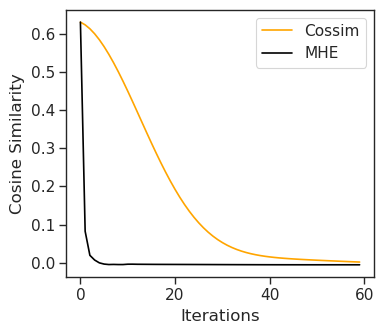

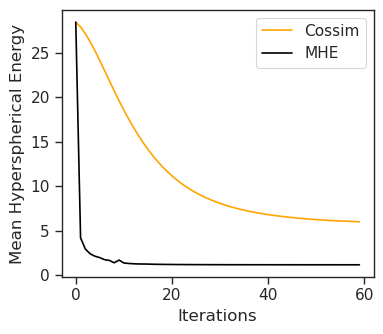

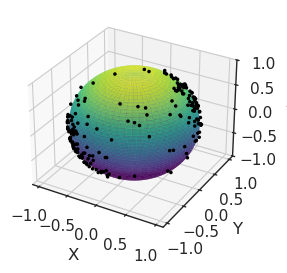

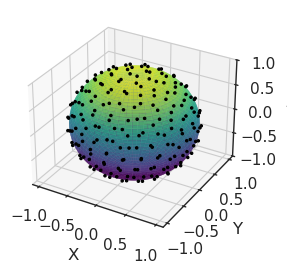

In [12]:
# create animation plot
def plot_animation(points, point_list, save_name=None):
  fig = plt.figure(figsize=(3, 3.5), dpi=100)
  ax = fig.add_subplot(projection='3d')
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)
  r = 0.975  # to avoid drawing over points/ easier to visualize
  x = r * np.outer(np.cos(u), np.sin(v))
  y = r * np.outer(np.sin(u), np.sin(v))
  z = r * np.outer(np.ones(np.size(u)), np.cos(v))
  ax.plot_surface(x, y, z, vmin=-0.5, cmap='viridis', alpha=0.8, edgecolors='none')
  ax.set_zlim(-1.0, 1.0)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  sc = ax.scatter([], [], [], '.', color='black', s=3.0, alpha=1.0)
  def update(i):
    pt = point_list[i].cpu().numpy()
    pt = pt / np.linalg.norm(pt, axis=1, keepdims=True)
    sc._offsets3d = (pt[:, 0], pt[:, 1], pt[:, 2])
    return sc,
  ani = animation.FuncAnimation(fig, update, frames=len(point_list), blit=True)
  if save_name:
    ani.save(save_name, writer='imagemagick', fps=8)


# define opt to decrease cossim
def opt_steps(points, lr=0.4, n_steps=800, opt_method=p_cossim):
  points = points.clone()
  points.requires_grad_(True)  # move points themselves
  opt = torch.optim.SGD([points], lr=lr, momentum=0.9, nesterov=True)
  cossims = np.zeros(n_steps)
  mhes = np.zeros(n_steps)
  point_iter = []
  for i in range(n_steps):
    # points drift off sphere just slightly during opt so we need to re-normalize
    with torch.no_grad():
      points /= torch.norm(points, dim=1, keepdim=True)
    
    # compute mhe/cossim
    cossims[i] = p_cossim(points).item()
    mhes[i] = mhe(points).item()
    
    # add to point iter
    point_iter.append(points.detach().clone())
    
    # perform step with method
    opt.zero_grad()
    loss = opt_method(points)
    loss.backward()
    opt.step()
  return points.detach(), point_iter, mhes, cossims


def plot_graph(css, mhes, ymhe=False, save_name=None):
  fig, ax = plt.subplots(figsize=(4.0, 3.5))
  ax.set_xlabel('Iterations')
  ax.set_ylabel('Mean Hyperspherical Energy' if ymhe else 'Cosine Similarity')
  ax.plot(css, label='Cossim', color='orange')
  ax.plot(mhes, label='MHE', color='black')
  # ax.set_title('Optimizing with Cosine Similarity')
  ax.legend()
  fig.tight_layout()
  fig.show()
  
  if save_name:
    fig.savefig(save_name)


# optimize 
LR = 0.9
NUM_ITER = 60
PLOT_ANIMATION = True  # set to True if you want a GIF of the optimization, will save to current directory, and also be pretty slow
cs_final_points, cs_point_list, cs_mhes, cs_cossims = opt_steps(points, lr=LR, n_steps=NUM_ITER, opt_method=p_cossim)
mhe_final_points, mhe_point_list, mhe_mhes, mhe_cossims = opt_steps(points, lr=LR, n_steps=NUM_ITER, opt_method=mhe)
# print('COSSIM', p_cossim(final_points))

print('Optimization method: Cossim')
print('Final cossim', p_cossim(cs_final_points))
print('Final mhe', mhe(cs_final_points))
print()
print('Optimization method: MHE')
print('Final cossim', p_cossim(mhe_final_points))
print('Final mhe', mhe(mhe_final_points))
print()

# Plot cossim when optimizing cossim vs mhe
plot_graph(cs_cossims, mhe_cossims, save_name='cossim_vs_mhe_ckas.pdf')

# Plot MHE when optimizing cossim vs mhe
plot_graph(cs_mhes, mhe_mhes, ymhe=True, save_name='cossim_vs_mhe_mhes.pdf')

# plot animation
if PLOT_ANIMATION:  # False  # comment/uncomment to test animation
  plot_animation(points, cs_point_list, save_name='cossim_opt.gif')
  plot_animation(points, mhe_point_list, save_name='mhe_opt.gif')

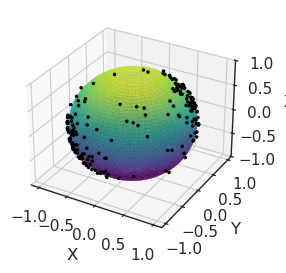

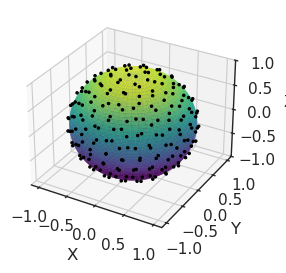

In [5]:
# Plot the final points
plot_points(cs_final_points, save_name='cossim_opt.pdf')
plot_points(mhe_final_points, save_name='mhe_opt.pdf')

# Learning Rate Adjustment
Adjust learning rates of each method until their max to compare

Optimization method: Cossim
Final cossim tensor(-0.0050)
Final mhe tensor(6.0313)

Optimization method: MHE
Final cossim tensor(-0.0050)
Final mhe tensor(1.1480)



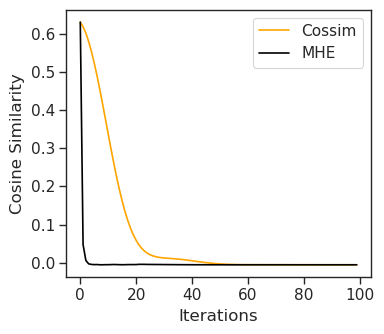

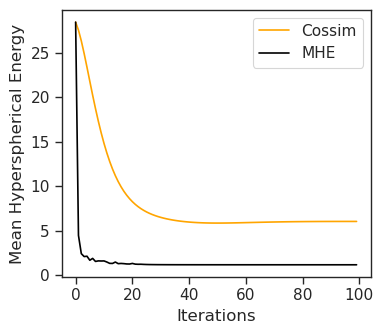

In [6]:
# optimize 
NUM_ITER = 100
cs_final_points, cs_point_list, cs_mhes, cs_cossims = opt_steps(points, lr=1.5, n_steps=NUM_ITER, opt_method=p_cossim)
mhe_final_points, mhe_point_list, mhe_mhes, mhe_cossims = opt_steps(points, lr=1.5, n_steps=NUM_ITER, opt_method=mhe)
# print('COSSIM', p_cossim(final_points))

print('Optimization method: Cossim')
print('Final cossim', p_cossim(cs_final_points))
print('Final mhe', mhe(cs_final_points))
print()
print('Optimization method: MHE')
print('Final cossim', p_cossim(mhe_final_points))
print('Final mhe', mhe(mhe_final_points))
print()

# Plot cossim when optimizing cossim vs mhe
plot_graph(cs_cossims, mhe_cossims)

# Plot MHE when optimizing cossim vs mhe
plot_graph(cs_mhes, mhe_mhes, ymhe=True)

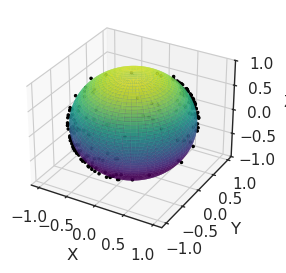

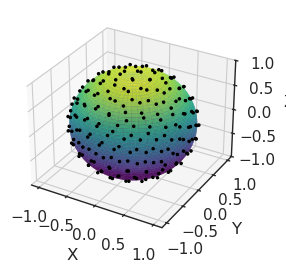

In [7]:
# Plot the final points
plot_points(cs_final_points, save_name='cossim_opt.pdf')
plot_points(mhe_final_points, save_name='mhe_opt.pdf')

# Higher Dimensional Example
To show this working in higher dimensional data let's work with $N=1000$

In [8]:
N = 1000
hquad_one = torch.normal(5.0, 2.1, size=(100, N))
hquad_one[:, 1] *= -1
hquad_one /= torch.norm(hquad_one, dim=1, keepdim=True)

hquad_two = (hquad_one * 2.0)
hquad_two[:, 0] *= -1
hquad_two /= torch.norm(hquad_two, dim=1, keepdim=True)

hpoints = torch.cat([hquad_one, hquad_two], dim=0)

print('Initial cosine similarity', p_cossim(hpoints))
print('Initial MHE', mhe(hpoints))

Initial cosine similarity tensor(0.8500)
Initial MHE tensor(5.8622)


Point dimension 1000
Optimization method: Cossim
Final cossim tensor(-0.0045)
Final mhe tensor(0.9163)

Optimization method: MHE
Final cossim tensor(-0.0049)
Final mhe tensor(0.4287)



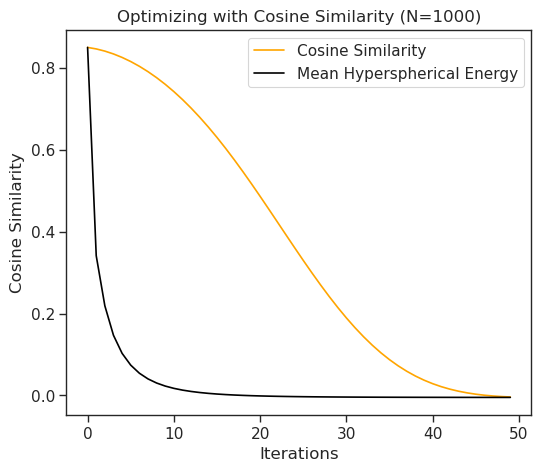

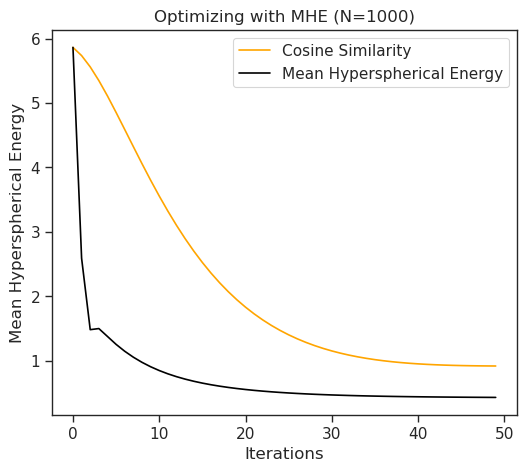

In [9]:
# optimize 
LR = 0.75
NUM_ITER = 50
cs_final_points, cs_point_list, cs_mhes, cs_cossims = opt_steps(hpoints, lr=LR, n_steps=NUM_ITER, opt_method=p_cossim)
mhe_final_points, mhe_point_list, mhe_mhes, mhe_cossims = opt_steps(hpoints, lr=LR, n_steps=NUM_ITER, opt_method=mhe)
# print('COSSIM', p_cossim(final_points))

print('Point dimension', cs_final_points.shape[1])
print('Optimization method: Cossim')
print('Final cossim', p_cossim(cs_final_points))
print('Final mhe', mhe(cs_final_points))
print()
print('Optimization method: MHE')
print('Final cossim', p_cossim(mhe_final_points))
print('Final mhe', mhe(mhe_final_points))
print()

# Plot cossim when optimizing cossim vs mhe
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlabel('Iterations')
ax.set_ylabel('Cosine Similarity')
ax.plot(cs_cossims, label='Cosine Similarity', color='orange')
ax.plot(mhe_cossims, label='Mean Hyperspherical Energy', color='black')
ax.set_title('Optimizing with Cosine Similarity (N=1000)')
ax.legend()
fig.savefig('n1000-cossim.pdf')
plt.show()

# Plot MHE when optimizing cossim vs mhe
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Hyperspherical Energy')
ax.plot(cs_mhes, label='Cosine Similarity', color='orange')
ax.plot(mhe_mhes, label='Mean Hyperspherical Energy', color='black')
ax.set_title('Optimizing with MHE (N=1000)')
ax.legend()
fig.savefig('n1000-mhe.pdf')
plt.show()

# Underperscribed case. High dim low number of points

In [10]:
N = 10_000
hquad_one = torch.normal(5.0, 2.1, size=(10, N))
hquad_one[:, 1] *= -1
hquad_one /= torch.norm(hquad_one, dim=1, keepdim=True)

hquad_two = (hquad_one * 2.0)
hquad_two[:, 0] *= -1
hquad_two /= torch.norm(hquad_two, dim=1, keepdim=True)

hpoints = torch.cat([hquad_one, hquad_two], dim=0)

print('Initial cosine similarity', p_cossim(hpoints))
print('Initial MHE', mhe(hpoints))

Initial cosine similarity tensor(0.8582)
Initial MHE tensor(102.4186)


Point dimension 10000
Optimization method: Cossim
Final cossim tensor(-0.0524)
Final mhe tensor(23.9319)

Optimization method: MHE
Final cossim tensor(-0.0526)
Final mhe tensor(0.4179)



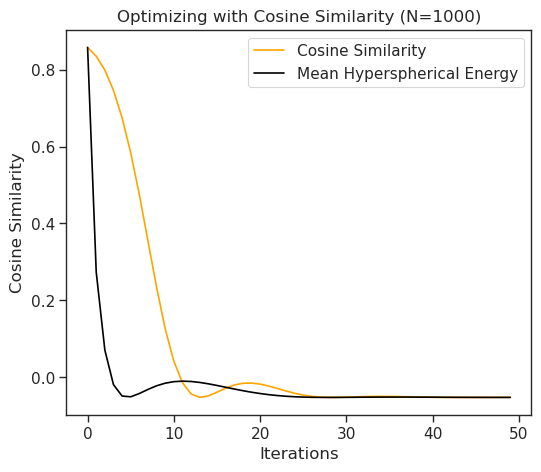

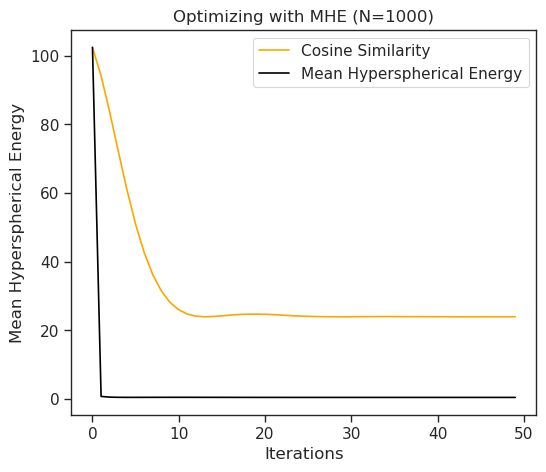

In [11]:
from functools import partial

# optimize 
LR = 0.45
NUM_ITER = 50
cs_final_points, cs_point_list, cs_mhes, cs_cossims = opt_steps(hpoints, lr=LR, n_steps=NUM_ITER, opt_method=p_cossim)
mhe_final_points, mhe_point_list, mhe_mhes, mhe_cossims = opt_steps(hpoints, lr=LR, n_steps=NUM_ITER, opt_method=partial(mhe, arc_eps=1e-2))
# print('COSSIM', p_cossim(final_points))

print('Point dimension', cs_final_points.shape[1])
print('Optimization method: Cossim')
print('Final cossim', p_cossim(cs_final_points))
print('Final mhe', mhe(cs_final_points))
print()
print('Optimization method: MHE')
print('Final cossim', p_cossim(mhe_final_points))
print('Final mhe', mhe(mhe_final_points))
print()

# Plot cossim when optimizing cossim vs mhe
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlabel('Iterations')
ax.set_ylabel('Cosine Similarity')
ax.plot(cs_cossims, label='Cosine Similarity', color='orange')
ax.plot(mhe_cossims, label='Mean Hyperspherical Energy', color='black')
ax.set_title('Optimizing with Cosine Similarity (N=1000)')
ax.legend()
fig.savefig('n1000-cossim.pdf')
plt.show()

# Plot MHE when optimizing cossim vs mhe
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Hyperspherical Energy')
ax.plot(cs_mhes, label='Cosine Similarity', color='orange')
ax.plot(mhe_mhes, label='Mean Hyperspherical Energy', color='black')
ax.set_title('Optimizing with MHE (N=1000)')
ax.legend()
fig.savefig('n1000-mhe.pdf')
plt.show()